In [1]:
import pdb 
import os
import random
import numpy as np
import scipy.stats as ss
import pandas as pd
import warnings
from tensorflow.python.keras.utils import Sequence  # pylint: disable-msg=E0611
from tensorflow.python.keras.callbacks import Callback, ModelCheckpoint  # pylint: disable-msg=E0611
from tensorflow.python.keras import backend as K  # pylint: disable-msg=E0611
from tensorflow.python.keras.preprocessing.text import text_to_word_sequence  # pylint: disable-msg=E0611
from tensorflow import ConfigProto, Session, map_fn, float32, is_finite, boolean_mask
from tensorflow.contrib.metrics import streaming_pearson_correlation
from tensorflow.contrib.saved_model import save_keras_model
from tensorflow.python.keras.models import save_model  # pylint: disable-msg=E0611
from numpy.random import choice
np.random.seed(1)
import tensorflow as tf
from tensorflow.python.keras import optimizers

In [2]:
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.initializers import glorot_uniform
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import (
    Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Layer)
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.python.keras import initializers, regularizers, constraints
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'


# class ScoreReader():
#     def __init__(self, csv_path, cv_directory
#                  system_idx=-1, fname_idx=0, score_idx=2, testname_idx=None,
#                  count_words=False, nan_val=''
#                 ):
#         self.csv_path = csv_path
#         self.cv_directory = cv_directory  # in order to prune non-existing files
#         self.system_idx = system_idx
#         self.fname_idx = fname_idx
#         self.score_idx = score_idx
#         self.testname_idx = testname_idx
#         self.testnames = []
#         self.nan_val = nan_val
#         self.read_scores(count_words)
#         random.shuffle(self.scores)
#         if not isinstance(self.score_idx, list):
#             s = pd.Series([t[1] for t in self.scores])
#             s[s<2500].plot.hist(bins=10, alpha=0.5)

#     def get_word_len(self, filename):
#         with open(self.get_file_path(filename), 'r') as fh:
#             lines = fh.read()
#             return len(text_to_word_sequence(lines))
#         return None

#     def get_file_path(self, filename):
#         return self.cv_directory + filename

#     @classmethod
#     def percentile2zscore(cls, percentile):
#         if percentile < 1:
#             percentile = 1
#         elif percentile > 99:
#             percentile = 99
#         return 0.5 + 0.4 * ss.norm.ppf(percentile / 100)

#     @classmethod
#     def sten2zscore(cls, sten):
#         #Sten scores (for the entire population of results) have a mean of 5.5 and a standard deviation of 2.[1]
#         # z-scores have a mean of 0 and a standard deviation of 1
#         return (sten - 5.5) / 2

#     def get_score(self, fields, score_idx, testname_idx=None):
#         if isinstance(score_idx, list):
#             scores = []
#             for score_ix1 in score_idx:
#                 scores.append(self.get_score(fields, score_ix1, testname_idx))
#             return scores
#         else:
#             val = fields[score_idx]
#             if val != self.nan_val:
#                 score = float(val)
#             else:
#                 score = np.nan
#             if testname_idx is not None:
#                 self.testnames.append(fields[testname_idx].lower())
#                 # normalize:
#                 if 'sten' in fields[testname_idx].lower():
#                     score = score  # *= 10
#                 elif 'percentile' in fields[testname_idx].lower():
#                     score /= 10.1
#                 elif 'zero' in fields[testname_idx].lower():
#                     if score == 0.0:
#                         score = None
#                     else:
#                         score /= 10.1
#             if score is not None:
#                 return score
#             else:
#                 return None

#     def get_scores(self):
#         return np.array([score for _, score in self.scores])

#     def set_scores(self, scores):
#         if isinstance(scores, np.ndarray):
#             print('converting scores to list of lists...')
#             scores = scores.tolist()
#         assert len(scores) == len(self.scores)
#         filenames = [filename for filename, _ in self.scores]
#         self.scores = [(filename, score) for filename, score in zip(filenames, scores)]

#     def normalize_scores(self, ranking=False):
#         raw_scores = self.get_scores()
#         if raw_scores.ndim < 2:
#             raw_scores = raw_scores.reshape(-1, 1)
#         if ranking:
#             scores = ss.rankdata(raw_scores)
#             self.set_scores(raw_scores)
#         else:
#             new_scores = (
#                 raw_scores - np.nanmean(raw_scores, axis=0)
#             ) / np.nanstd(raw_scores, axis=0)
#             new_scores = [
#                 val if len(val)>1 else val[0]
#                 for val in new_scores.tolist()
#             ]
#             self.set_scores(new_scores)

#     def read_scores(self, count_words=False):
#         # read scores from csv file
#         with open(self.csv_path, 'r') as fh:
#             lines = fh.readlines()
        
#         print('parsing {} scores...'.format(len(lines)-1))
#         self.scores = []
#         self.word_count = []
#         skip = True
#         for line in lines:
#             if skip:
#                 print(line)
#                 fields = line.split(',')
#                 def print_labels(field_idx, name):
#                     if field_idx is not None:
#                         if isinstance(field_idx, list):
#                             print('{}: {}'.format(name, [fields[idx] for idx in field_idx]))
#                         else:
#                             print('{}: {}'.format(name, fields[field_idx]))
#                 print_labels(self.system_idx, 'system index')
#                 print_labels(self.score_idx, 'score index')
#                 print_labels(self.testname_idx, 'testname')
#                 print_labels(self.fname_idx, 'filename_idx')
#                 skip = False
#             else:
#                 fields = line.split(',')
#                 fields[-1] = fields[-1].strip()
#                 filename = str(fields[self.system_idx]).zfill(3) + '/' + fields[self.fname_idx] + '.txt'
#                 if os.path.exists(self.get_file_path(filename)):
#                     score = self.get_score(fields, self.score_idx, self.testname_idx)
                    
                    
# #                     print('score 0000000000000000000')
# #                     print(self.score_idx)
# # #                     print(len(score))
# # #                     print(score)
# #                     pdb.set_trace()
                    
                    
#                     if score is not None:
#                         self.scores.append((filename, score))
#                     if count_words:
#                         self.word_count.append(self.get_word_len(filename))
#                 else:
#                     print('{} not found'.format(filename))
                
#         if len(self.scores) == 0:
#             raise ValueError('No data parsed!')
#         if not isinstance(self.score_idx, list):
#             score_vocab = set([score for _, score in self.scores])
#             print('{} different score values found'.format(len(score_vocab)))
#             print(score_vocab)
#         else:
#             print('dimensionality: {}'.format(len(self.scores[0][1])))
#         print('{} scores parsed'.format(len(self.scores)))

#     def split_train_test(self, train_fraction=0.9, val_fraction=0.6):
#         split = train_fraction * len(self.scores)
        
#         trainScores = []
#         registerScores = []
#         for count, score in enumerate(self.scores):
#             if count<split:
#                 trainScores.append(score)
#             else:
#                 registerScores.append(score)
        
#         valScores = []
#         testScores = []
#         split1 = val_fraction * len(registerScores)
#         for count, score in enumerate(registerScores):
#             if count<split1:
#                 valScores.append(score)
#             else:
#                 testScores.append(score)
                
#         print('{} train scores, {} val scores, {} test scores'.format(len(trainScores), len(valScores),len(testScores)))
#         return trainScores, valScores, testScores

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'


class ScoreReader():
    def __init__(self, csv_path, cv_directory,
                 system_idx=-1, fname_idx=0, score_idx=2, testname_idx=None,
                 count_words=False, nan_val=''
                ):
        self.csv_path = csv_path
        self.cv_directory = cv_directory  # in order to prune non-existing files
        self.system_idx = system_idx
        self.fname_idx = fname_idx
        self.score_idx = score_idx
        self.testname_idx = testname_idx
        self.testnames = []
        self.nan_val = nan_val
        self.read_scores(count_words)
        random.shuffle(self.scores)
        if not isinstance(self.score_idx, list):
            s = pd.Series([t[1] for t in self.scores])
            s[s<2500].plot.hist(bins=10, alpha=0.5)

    def get_word_len(self, filename):
        with open(self.get_file_path(filename), 'r') as fh:
            lines = fh.read()
            return len(text_to_word_sequence(lines))
        return None

    def get_file_path(self, filename):
        return self.cv_directory + filename

    @classmethod
    def percentile2zscore(cls, percentile):
        if percentile < 1:
            percentile = 1
        elif percentile > 99:
            percentile = 99
        return 0.5 + 0.4 * ss.norm.ppf(percentile / 100)

    @classmethod
    def sten2zscore(cls, sten):
        #Sten scores (for the entire population of results) have a mean of 5.5 and a standard deviation of 2.[1]
        # z-scores have a mean of 0 and a standard deviation of 1
        return (sten - 5.5) / 2

    def get_score(self, fields, score_idx, testname_idx=None):
        if isinstance(score_idx, list):
            scores = []
            for score_ix1 in score_idx:
                scores.append(self.get_score(fields, score_ix1, testname_idx))
            return scores
        else:
            val = fields[score_idx]
            if val != self.nan_val:
                score = float(val)
            else:
                score = np.nan
            if testname_idx is not None:
                self.testnames.append(fields[testname_idx].lower())
                # normalize:
                if 'sten' in fields[testname_idx].lower():
                    score = score  # *= 10
                elif 'percentile' in fields[testname_idx].lower():
                    score /= 10.1
                elif 'zero' in fields[testname_idx].lower():
                    if score == 0.0:
                        score = None
                    else:
                        score /= 10.1
            if score is not None:
                return score
            else:
                return None

    def get_scores(self):
        return np.array([score for _, score in self.scores])

    def set_scores(self, scores):
        if isinstance(scores, np.ndarray):
            print('converting scores to list of lists...')
            scores = scores.tolist()
        assert len(scores) == len(self.scores)
        filenames = [filename for filename, _ in self.scores]
        self.scores = [(filename, score) for filename, score in zip(filenames, scores)]

    def normalize_scores(self, ranking=False):
        raw_scores = self.get_scores()
        if raw_scores.ndim < 2:
            raw_scores = raw_scores.reshape(-1, 1)
        if ranking:
            scores = ss.rankdata(raw_scores)
            self.set_scores(raw_scores)
        else:
            new_scores = (
                raw_scores - np.nanmean(raw_scores, axis=0)
            ) / np.nanstd(raw_scores, axis=0)
            new_scores = [
                val if len(val)>1 else val[0]
                for val in new_scores.tolist()
            ]
            self.set_scores(new_scores)

    def read_scores(self, count_words=False):
        # read scores from csv file
        with open(self.csv_path, 'r') as fh:
            lines = fh.readlines()
        
        print('parsing {} scores...'.format(len(lines)-1))
        self.scores = []
        self.word_count = []
        skip = True
        for line in lines:
            if skip:
                print(line)
                fields = line.split(',')
                def print_labels(field_idx, name):
                    if field_idx is not None:
                        if isinstance(field_idx, list):
                            print('{}: {}'.format(name, [fields[idx] for idx in field_idx]))
                        else:
                            print('{}: {}'.format(name, fields[field_idx]))
                print_labels(self.system_idx, 'system index')
                print_labels(self.score_idx, 'score index')
                print_labels(self.testname_idx, 'testname')
                print_labels(self.fname_idx, 'filename_idx')
                skip = False
            else:
                fields = line.split(',')
                fields[-1] = fields[-1].strip()
                filename = str(fields[self.system_idx]).zfill(3) + '/' + fields[self.fname_idx] + '.txt'
                if os.path.exists(self.get_file_path(filename)):
                    score = self.get_score(fields, self.score_idx, self.testname_idx)
                    
                    
#                     print('score 0000000000000000000')
#                     print(self.score_idx)
# #                     print(len(score))
# #                     print(score)
#                     pdb.set_trace()
                    
                    
                    if score is not None:
                        self.scores.append((filename, score))
                    if count_words:
                        self.word_count.append(self.get_word_len(filename))
                else:
                    print('{} not found'.format(filename))
                
        if len(self.scores) == 0:
            raise ValueError('No data parsed!')
        if not isinstance(self.score_idx, list):
            score_vocab = set([score for _, score in self.scores])
            print('{} different score values found'.format(len(score_vocab)))
            print(score_vocab)
        else:
            print('dimensionality: {}'.format(len(self.scores[0][1])))
        print('{} scores parsed'.format(len(self.scores)))

    def split_train_test(self, train_fraction=0.9, val_fraction=0.6):
        split = train_fraction * len(self.scores)
        
        trainScores = []
        registerScores = []
        for count, score in enumerate(self.scores):
            if count<split:
                trainScores.append(score)
            else:
                registerScores.append(score)
        
        valScores = []
        testScores = []
        split1 = val_fraction * len(registerScores)
        for count, score in enumerate(registerScores):
            if count<split1:
                valScores.append(score)
            else:
                testScores.append(score)
                
        print('{} train scores, {} val scores, {} test scores'.format(len(trainScores), len(valScores),len(testScores)))
        return trainScores, valScores, testScores

In [4]:
maxlen=1024
batch_size=256
score_reader = ScoreReader(
    '/u02/datasets/psytesting/scores_combined.csv',
    '/u02/texts/' ,count_words=False,
    system_idx=-1, fname_idx=-2,
    score_idx=list(range(31)),
    testname_idx=None,
)
score_reader.normalize_scores()
# print(score_reader)

parsing 430158 scores...
achieving a safe and secure environment,achieving commercial outcomes,analyst_0,building capability for all,candidate_grade,caring,changing and improving,collaborating and partnering,customer_0,delivering at pace,delivering value for money,job_grade,leading and communicating,making effective decisions,managing a quality service,numerical,opq32 big 5 great 8 scales ocf_g8_f1_sten_new,opq32 big 5 great 8 scales ocf_g8_f2_sten_new,opq32 big 5 great 8 scales ocf_g8_f3_sten_new,opq32 big 5 great 8 scales ocf_g8_f4_sten_new,opq32 big 5 great 8 scales ocf_g8_f5_sten_new,opq32 big 5 great 8 scales ocf_g8_f6_sten_new,opq32 big 5 great 8 scales ocf_g8_f7_sten_new,opq32 big 5 great 8 scales ocf_g8_f8_sten_new,other competency/experience,persuading and influencing,professional competency,sat_0,seeing the big picture,showing drive and resilience,verbal,filename,system_id

system index: system_id

score index: ['achieving a safe and secure environment', 'achieving commercial

In [5]:
trainScores, valScores, testScores = score_reader.split_train_test(0.9,0.6)


387094 train scores, 25806 val scores, 17204 test scores


In [6]:
# filename1=[]
# score1=[]
# for i,data in enumerate(trainScores):
#     filename1.append(trainScores[i][0])
#     score1.append(trainScores[i][1])

testScores[1]


('423/file_private_423_f4e6b81e49e1426032c3e78191b4248b9f200b6a.doc.txt',
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.9006659627864377,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan])

In [54]:
# score1

[[nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  -0.34447713777312033,
  nan,
  nan,
  nan],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  0.0986953934119559,
  nan,
  nan,
  nan],
 [nan,
  nan,
  1.0634764873555071,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 [nan,
  2.0507756146787375,
  nan,
  nan,
  nan,
  nan,
  2.936457687512048,
  3.0563767137779587,
  nan,
  2.2486297860694506,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  2.3138903521414758,
  nan,
  nan],
 [nan,


In [28]:
train_df = pd.read_csv('/u02/datasets/psytesting/scores_combined.csv',encoding="latin-1")
train_df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,achieving a safe and secure environment,achieving commercial outcomes,analyst_0,building capability for all,candidate_grade,caring,changing and improving,collaborating and partnering,customer_0,delivering at pace,...,opq32 big 5 great 8 scales ocf_g8_f8_sten_new,other competency/experience,persuading and influencing,professional competency,sat_0,seeing the big picture,showing drive and resilience,verbal,filename,system_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.422856,NaN,...,-1.819622,NaN,NaN,NaN,NaN,NaN,NaN,-1.076971,file_private_166_1ebe0849197c26459303f4f7067ca...,166
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507348,NaN,...,-1.236188,NaN,NaN,NaN,NaN,NaN,NaN,-1.076971,file_private_166_459139584c6199739f72be71f8bb2...,166
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.753010,NaN,...,0.514113,NaN,NaN,NaN,NaN,NaN,NaN,-0.330382,file_private_166_5bcbd46110c94bb844c0d35992fd9...,166
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.507348,NaN,...,-1.236188,NaN,NaN,NaN,NaN,NaN,NaN,-0.077672,file_private_166_cf5cd559f15306495ea9918637277...,166
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.279430,NaN,...,-1.236188,NaN,NaN,NaN,NaN,NaN,NaN,-1.823560,file_private_166_c76746b9456d6813ea9af366e3c53...,166


In [29]:
class Embeddings():
    '''Word embeddings class
    '''
    def __init__(self, glove_path,
                 cv_directory, maxlen, lower=False):
        self.glove_path = glove_path
        self.cv_directory = cv_directory
        self.maxlen = maxlen
        self.lower = lower
        self.read_embeddings(self.glove_path)

    def read_embeddings(self, glove_path):
        '''Read embeddings from glove/word2vec files.
        '''
        self.vocab = dict()
        self.embedding = []

        with open(glove_path, 'r', encoding='utf-8') as glove_file_handle:
            for line_no, line in enumerate(glove_file_handle):
                line = line.strip()
                #if self.lower:
                #    line = line.lower()
                elems = line.split()
                if (line_no == 1) and ((len(elems)-1) > self.embedding[0].size):
                    # for word2vec remove the first line
                    self.vocab = dict()
                    self.embedding = []
                elif ((line_no > 0) and (len(elems)-1) != self.embedding[0].size):
                    continue
                word = elems[0].strip()
                vec = np.zeros(len(elems)-1, dtype=float)
                for ind, val in enumerate(elems[1:]):
                    vec[ind] = float(val)
                self.embedding.append(vec)
                self.vocab[word] = len(self.vocab)

        self.embedding.append(np.zeros(self.embedding_dim()))
        self.vocab['PADDING_TOKEN'] = len(self.vocab)

        self.embedding.append(np.zeros(self.embedding_dim()))
        self.vocab['——'] = len(self.vocab)

        if 'UNKNOWN_TOKEN' not in self.vocab:
            self.embedding.append(np.random.uniform(-0.25, 0.25, self.embedding_dim()))
            self.vocab['UNKNOWN_TOKEN'] = len(self.vocab)

    def embedding_dim(self):
        return self.embedding[0].size


    def get_file_path(self, filename):
        return self.cv_directory + filename

    def __get_text__(self, filename):
        with open(self.get_file_path(filename), 'r', encoding='utf-8') as fh:
            lines = fh.read()
        return lines

    def __get_data__(self, filename):
        text = self.__get_text__(filename)
        return self.__embed_text__(text)

    def embedding_index(self, token):
        if token in self.vocab:
            return self.vocab[token]
        elif token.lower() in self.vocab:
            return self.vocab[token.lower()]
        else:
            return self.vocab['UNKNOWN_TOKEN']

    def embed_token(self, token):
        return self.embedding[self.embedding_index(token)]

    def __embed_text__(self, text, maxlen=None):
        if maxlen is None:
            maxlen = self.maxlen
        text_embedded = []
        for word in text_to_word_sequence(text, lower=self.lower):
            text_embedded.append(self.embed_token(word))
            if len(text_embedded) >= maxlen:
                break
        while len(text_embedded) < maxlen:  # padding if necessary
            text_embedded.append(np.zeros(self.embedding[0].shape))
        return text_embedded

    def embedding_indexes(self, text, maxlen=None):
        if maxlen is None:
            maxlen = self.maxlen
        text_embedded = []
        for word in text_to_word_sequence(text, lower=self.lower):
            text_embedded.append(self.embedding_index(word))
            if len(text_embedded) >= maxlen:
                break
        while len(text_embedded) < maxlen:  # padding if necessary
            text_embedded.append(self.vocab['UNKNOWN_TOKEN'])
        return text_embedded

In [30]:
embeddings = Embeddings(
    glove_path='/home/calvin/glove.6B.50d.txt',
    cv_directory='/u02/texts/', maxlen=maxlen,
    lower=True)

In [31]:
read_embeddings=embeddings.read_embeddings('/home/calvin/glove.6B.50d.txt')

In [35]:
aa=embeddings.__get_text__('188/file_private_188_624d35d35f6fc0b170d20b9cd9936b38796c91b7.docx.txt')

In [56]:
type([aa])

list

In [57]:
[aa]

["Aaron Sacks\n305 Grandview Circle, Ridgewood, NJ 07450 ? Hamilton, NY 13346 ? asacks@colgate.edu ? 201.835.6319\n\nEDUCATION\n\nColgate University, Bachelor of Arts, Hamilton, NY                                                                                                   May 2016\n?GPA 3.6/4.0                                                                                                \n     ?Major: Economics  \n?Dean?s Award for Academic Excellence Recipient                                                                                               All Semesters\n?Phi Eta Sigma Academic Honor Society                                                                                                                       Fall 2013\n?Study Abroad at the University of Edinburgh, Scotland                                                                                               Fall 2014                                        \n\nEXPERIENCE\n\nLazard Asset Management, New York, 

In [9]:
# print(embeddings.embedding_indexes())

In [10]:
# aaa=score_reader.set_scores(a)
# print(aaa)

In [11]:
# trainScores, testScores=score_reader.split_train_test()
# print(testScores[2])
# print(len(testScores[2]))
# print(type(testScores))
# print(len(testScores))
# print(len(trainScores))

In [36]:
class CV2EmbeddingDataGenerator(Sequence):
    def __init__(self, scores, embedding, maxlen, batch_size=batch_size, output_dim=2,
                 system_ids=['166',  '188',  '221', '286',  '349',  '372',  '417',  '042',  '427',  '428',  '043', \
                    '048',  '495',  '051'],):
        self.scores = scores # input: trainScores or testScores
        self.embedding = embedding # embeddings.embedding
        self.maxlen= maxlen
        self.batch_size = batch_size
        self.output_dim = output_dim
        self.on_epoch_end()
        self.system_ids   = system_ids
        if isinstance(self.scores[0][1], list):
            self.dim = len(self.scores[0][1])
        else:
            self.dim = 1

    def on_epoch_end(self):

        self.indexes = list(range(len(self.scores)))
        random.shuffle(self.indexes)

    # just input sequencially for index into NN -> 0,1,2,3... 
    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        trainX = np.zeros((self.batch_size, self.maxlen, self.embedding[0].size))
        if self.output_dim == 2:
            trainY = np.zeros((self.batch_size, self.dim))
        else:
            trainY = np.zeros((self.batch_size, 1, self.dim))

        for batch, ind in enumerate(indexes):
            filename, score = self.scores[ind]
            trainX[batch, :, :] = np.array(embeddings.__get_data__(filename))
            if isinstance(score, list):
                if self.output_dim == 2:
                    trainY[batch, :] = np.array(score)
                else:
                    trainY[batch, :, :] = np.array([score])
            else:
                if self.output_dim == 2:
                    trainY[batch, :] = np.array([score])
                else:
                    trainY[batch, :, :] = np.array([[score]])
        return trainX, trainY

    def __len__(self):
        return int(np.floor(len(self.scores) / self.batch_size))
    
#     def data_generation_NN(self, batch_size):  # for testing
#         while 1:
#             for i in range(self.__len__()):
#                 X, Y=self.__getitem__(i)
#                 return X, Y
            
    def data_generation_NN(self, batch_size):
        while 1:
            self.on_epoch_end()
            for i in range(self.__len__()):
                X, Y = self.__getitem__(i)
                yield X, Y                
                

In [14]:
# np.array(embeddings.__get_data__(filename))

In [15]:
training_generator = CV2EmbeddingDataGenerator(
    trainScores, embeddings.embedding, maxlen=maxlen,
    batch_size=batch_size
)

val_generator = CV2EmbeddingDataGenerator(
    valScores, embeddings.embedding, maxlen=maxlen,
    batch_size=batch_size
)



In [16]:
# xx,yy=training_generator.data_generation_NN(batch_size)
# print(yy[0,:])

In [17]:
# print(xx[2,:,1])

In [18]:
training_generator.on_epoch_end()

In [19]:
X1,Y1 =training_generator.__getitem__(0)
# print(trainY1)

In [20]:
training_generator.__len__()

1512

In [21]:
print(len(Y1))
print(Y1)

256
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan 1.06347649 ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ... 0.79112558        nan        nan]
 [       nan        nan        nan ...        nan        nan 0.77416047]]


In [22]:
from tensorflow.keras import backend as K
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.python.keras.layers import Layer
import tensorflow as tf

In [71]:
import random
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """
 
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        input_shape_ints = input_shape.as_list()
        assert len(input_shape) == 3
 
        self.W = self.add_weight(
            shape=(input_shape_ints[-1], input_shape_ints[-1],),
            initializer=self.init,
            regularizer=self.W_regularizer,
            constraint=self.W_constraint,
            name=self.name + '_W'
        )
        if self.bias:
            self.b = self.add_weight(
                shape=(input_shape_ints[-1],),
                initializer='zero',
                regularizer=self.b_regularizer,
                constraint=self.b_constraint,
                name=self.name + '_b'
            )
 
        self.u = self.add_weight(
            shape=(input_shape_ints[-1],),
            initializer=self.init,
            regularizer=self.u_regularizer,
            constraint=self.u_constraint,
            name=self.name + '_u'
        )
 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
 
        a = K.exp(ait)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [24]:
# def use_cpu(use_gpu=False, num_cores=4):
#     '''switch on or off the use of GPU for computations
#     '''
#     if use_gpu:
#         num_gpu = 1
#         num_cpu = 1
#     else:  # CPU
#         num_cpu = 10
#         num_gpu = 0

#     config = ConfigProto(intra_op_parallelism_threads=num_cores,\
#             inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
#             device_count = {'CPU' : num_cpu, 'GPU' : num_gpu})
#     session = Session(config=config)
#     K.set_session(session)
    
# use_cpu()


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [278]:
tf.reset_default_graph()
tf.keras.backend.clear_session()
from tensorflow.contrib.metrics import streaming_pearson_correlation

# Design model
model = Sequential()
model.add(Bidirectional(LSTM(units=128,return_sequences=True, dropout=0.3,recurrent_dropout=0.3),
                        input_shape=(None,embeddings.embedding[0].size)))
model.add(Bidirectional(LSTM(units=64,return_sequences=True, dropout=0.3,recurrent_dropout=0.3),
                        input_shape=(None,embeddings.embedding[0].size)))
model.add(AttentionWithContext())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(31, activation=None))


def rmse_nan(y_true, y_pred):
    index = tf.math.is_nan(y_true)
    y_true = boolean_mask(y_true, index)
    y_pred = boolean_mask(y_pred, index)
    return K.sqrt(K.mean((y_true - y_pred) ** 2))

def filter_nans(y_true2, y_pred2):
    '''filter out nan values
    '''
    bool_finite = is_finite(y_true2)
    y_true = boolean_mask(y_true2, bool_finite)
    y_pred = boolean_mask(y_pred2, bool_finite)
    return y_true, y_pred

def nanmse(y_true2, y_pred2):
    y_true, y_pred = filter_nans(y_true2, y_pred2)
    return K.mean(K.square(y_pred - y_true), axis=-1)



def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]


model.compile(
    loss=rmse_nan,
    optimizer=adam,metrics=[tf_pearson])
# adam=optimizers.adam(lr=0.0005)
# model.compile(loss=nanmse, optimizer=adam)



model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 256)         183296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         164352    
_________________________________________________________________
attention_with_context (Atte (None, 128)               16640     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
__________

In [26]:
history=model.fit_generator(
    generator=training_generator,
    use_multiprocessing=True,
    workers=1, epochs=20, 
    validation_data=val_generator,
)

# model.fit_generator(generator=training_generator.data_generation_NN(batch_size),
#                 use_multiprocessing=True,
#                 workers=30, epochs=10, steps_per_epoch=training_generator.__len__(), 
#                validation_data=val_generator.data_generation_NN(batch_size),
#                 validation_steps=val_generator.__len__())
    
#     model_performance.append((i, errors))
#     i=i+1

# saved_to_path = tf.contrib.saved_model.save_keras_model(
#       model, '/home/calvin/model_v14-new_keras.hdf5')


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
1512/1512 [==============================] - 12031s 8s/step - loss: 1.0015 - val_loss: 0.9780
Epoch 2/20
1512/1512 [==============================] - 12187s 8s/step - loss: 0.9562 - val_loss: 0.9333
Epoch 3/20
 418/1512 [=======>......................] - ETA: 2:17:23 - loss: 0.9353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1512/1512 [==============================] - 11976s 8s/step - loss: 0.9095 - val_loss: 0.9027
Epoch 5/20
1512/1512 [==============================] - 11990s 8s/step - loss: 0.8986 - val_loss: 0.8938
Epoch 6/20
1512/1512 [==============================] - 11630s 8s/step - loss: 0.8897 - val_loss: 0.8912
Epoch 7/20
1512/1512 [==============================] - 12032s 8s/step - loss: 0.8837 - val_loss: 0.8941
Epoch 8/20
1512/1512 [==============================] - 12257s 8s/step - loss: 0.8783 - val_loss: 0.8850
Epoch 9/20
1512/1512 [==============================] - 11938s 8s/step - loss: 0.8723 - val_loss: 0.8852
Epoch 10/20
1512/1512 [==============================] - 12328s 8s/step - loss: 0.8690 - val_loss: 0.8757
Epoch 11/20
1512/1512 [==============================] - 12289s 8s/step - loss: 0.8516 - val_loss: 0.8679
Epoch 15/20
1512/1512 [==============================] - 12288s 8s/step - loss: 0.8484 - val_loss: 0.8688
Epoch 16/20
1512/1512 [==============================] - 11968s

In [41]:
# saved_to_path = tf.contrib.saved_model.save_keras_model(
#       model, '/home/calvin/model_v14-new_keras')
model.save_weights( '/home/calvin/model_v14-new_keras.hdf5')

In [42]:
model.load_weights('/home/calvin/model_v14-new_keras.hdf5', by_name=False)

In [43]:
history=model.fit_generator(
    generator=training_generator,
    use_multiprocessing=True,
    workers=1, epochs=20, 
    validation_data=val_generator,
)

Epoch 1/20
1512/1512 [==============================] - 11330s 7s/step - loss: 0.8340 - val_loss: 0.8596
Epoch 2/20
1512/1512 [==============================] - 12293s 8s/step - loss: 0.8324 - val_loss: 0.8507
Epoch 3/20
1512/1512 [==============================] - 12371s 8s/step - loss: 0.8312 - val_loss: 0.8558
Epoch 4/20
1512/1512 [==============================] - 10666s 7s/step - loss: 0.8290 - val_loss: 0.8563
Epoch 5/20
1243/1512 [=======================>......] - ETA: 33:47 - loss: 0.8283

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1512/1512 [==============================] - 12321s 8s/step - loss: 0.8259 - val_loss: 0.8554
Epoch 7/20
1512/1512 [==============================] - 12020s 8s/step - loss: 0.8250 - val_loss: 0.8522
Epoch 8/20
1512/1512 [==============================] - 11365s 8s/step - loss: 0.8223 - val_loss: 0.8523
Epoch 9/20
1512/1512 [==============================] - 12164s 8s/step - loss: 0.8212 - val_loss: 0.8515
Epoch 10/20
 689/1512 [============>.................] - ETA: 1:46:30 - loss: 0.8196

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1512/1512 [==============================] - 12059s 8s/step - loss: 0.8211 - val_loss: 0.8481
Epoch 11/20
1512/1512 [==============================] - 12028s 8s/step - loss: 0.8189 - val_loss: 0.8536
Epoch 12/20
1512/1512 [==============================] - 11001s 7s/step - loss: 0.8169 - val_loss: 0.8540
Epoch 13/20
1512/1512 [==============================] - 11749s 8s/step - loss: 0.8154 - val_loss: 0.8504
Epoch 15/20
1512/1512 [==============================] - 11696s 8s/step - loss: 0.8138 - val_loss: 0.8559
Epoch 16/20
 899/1512 [================>.............] - ETA: 1:19:41 - loss: 0.8138

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1512/1512 [==============================] - 10909s 7s/step - loss: 0.8124 - val_loss: 0.8500
Epoch 19/20
1512/1512 [==============================] - 10768s 7s/step - loss: 0.8106 - val_loss: 0.8493
Epoch 20/20
1512/1512 [==============================] - 10797s 7s/step - loss: 0.8108 - val_loss: 0.8470


dict_keys(['val_loss', 'loss'])


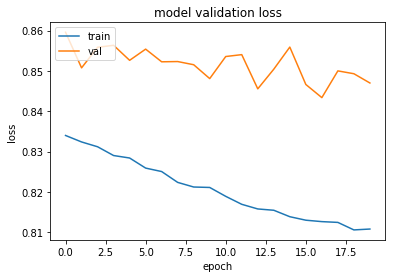

In [46]:
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model validation accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
test_generator = CV2EmbeddingDataGenerator(
    testScores, embeddings.embedding, maxlen=maxlen,
    batch_size=batch_size)

In [48]:
scoreSeg = model.evaluate_generator(test_generator.data_generation_NN(batch_size), test_generator.__len__())

In [49]:
print("loss = ",scoreSeg)

loss =  0.8363547405200218


In [104]:
# def filter_nans(y_true2, y_pred2):
#     '''filter out nan values
#     '''
#     bool_finite = is_finite(y_true2)
#     y_true = boolean_mask(y_true2, bool_finite)
#     y_pred = boolean_mask(y_pred2, bool_finite)
#     return y_true, y_pred 

# def nanloss(fun, y_true2, y_pred2):
#     '''Given a loss function, fun, apply it
#     while ignoring nans
#     Usage: nanloss(mae, y_true, y_pred)
#     '''
#     return map_fn(
#         lambda x: fun(*filter_nans(x[0], x[1])),
#         (y_true2, y_pred2),
#         dtype=float32
#     )

# def nanpearson(y_true2, y_pred2):
#     return nanloss(
#         streaming_pearson_correlation,
#         y_true2,
#         y_pred2
#     )

# score_pearson = model.predict_generator(test_generator.data_generation_NN(batch_size), 
#                                          test_generator.__len__())

In [303]:
# pearson=nanpearson(testScores[:][1],score_pearson)
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""

    # Compute correlation matrix
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat

aa=[testScores[1] for testScores in testScores]
print(np.array(aa).T.shape)
# print(np.array(np.array(aa))[:17152][2])
print(np.array(score_pearson)[2])

            

(31, 17204)
[ 0.5184887   0.42699608  0.00476377  0.44212067 -0.05158255  0.5212052
  0.41420484  0.39896592  0.00940554  0.4498478   0.19179994  0.0578734
  0.35588318  0.28647414  0.38259524  0.6289106   0.04396913 -0.09588902
 -0.10950597  0.608238    0.06566525 -0.08269485 -0.10513309  0.00674384
  0.5423461   0.52367365  1.1317637   0.17159234  0.43769866  0.36855814
  0.28144816]


In [311]:
# pearson_a=pearson_r(np.array(aa)[:17152].T, np.array(score_pearson).T)
aaa=np.array(aa)[:17152].T
bbb=np.array(score_pearson).T
print(aaa[1,:].shape)
print(bbb.shape)

(17152,)
(31, 17152)


In [324]:
pearson_res=[]
# www=pd.Series(aaaxxxbbb:]
# eee=pd.Series(bbb[2,:])
for i in range(31):
    pearson_res.append(pd.Series(aaa[i,:]).corr(pd.Series(bbb[i,:])))

In [327]:
pearson_res

[-0.007511939237106882,
 0.1257556055459453,
 -0.006342837655971886,
 0.027570032755142342,
 -0.015162568369653994,
 -0.05450381953455642,
 0.0326051009550335,
 0.0028584605657831874,
 0.027156713009948603,
 0.02081023945124826,
 -0.011600428578704802,
 -0.001626701626067214,
 -0.03379306399731905,
 0.01379020871833537,
 0.00895394021445351,
 -5.460510827013037e-05,
 0.01346844408167074,
 0.031294992189409614,
 -0.005115079197890398,
 -0.0024865271978700815,
 0.06003234373247881,
 0.005759835112291934,
 0.037967805353263565,
 0.009357512170352331,
 0.04193709377114497,
 0.039797058732550676,
 -0.08037126901429303,
 0.0008476402688943678,
 -0.008351082060126955,
 0.06337896878032821,
 -0.049079616385394736]

In [344]:
# finding p value------

# for i in range(31):
#     w=pd.concat(pd.Series(aaa[i,:],pd.Series(bbb[i,:])))
#     print(w)
#     ww=w.dropna(how='any')
#     print(ww)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "Series"

In [55]:
model.save_weights( '/home/calvin/model_v14-new_keras.hdf5')

In [291]:
model.load_weights('/home/calvin/model_v14-new_keras.hdf5', by_name=False)

In [80]:
from keras.models import load_model
model.save('/home/calvin/model_v14-baseline.h5')

In [81]:
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from tensorflow.keras.models import load_model

model = load_model('/home/calvin/model_v14-baseline.h5', 
                   custom_objects={'AttentionWithContext': AttentionWithContext,'nanmse' : nanmse})


In [1]:
1e-5/4


2.5e-06